In [20]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define the range for material constants as per Table 1 in the paper
E_range = [60e3, 210e3]  # MPa
sigma_y_range = [90, 1000]  # MPa
c_range = [1, 250e3]  # MPa
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1, 150]  # MPa


# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 500
NΔε = 1500

# Generate Latin Hypercube Sample for material constants
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))

# Generate strain history by accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain
    
    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain
    
    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    return strain_history

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated
        
        delta_gamma = newton(plastic_residual, 1e-5)  # Solve for plastic multiplier

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Generate dataset
def generate_dataset(lb,ub, num_material_samples=500, num_strain_samples=1500):
    material_constants = generate_material_constants_lhs(num_material_samples)
    strain_history = generate_strain_history(num_strain_samples,lb,ub)
    
    # Create Cartesian product: for each material constant set, apply all strain increments
    repeated_material_constants = np.repeat(material_constants, len(strain_history) // num_material_samples, axis=0)
    repeated_strain_history = np.tile(strain_history, num_material_samples)
    dataset = []
    
    for i in range(len(repeated_material_constants)):
        E, sigma_y, c, gamma, b, Q = repeated_material_constants[i, 0], repeated_material_constants[i, 1], \
                                     repeated_material_constants[i, 2:5], repeated_material_constants[i, 5:8], \
                                     repeated_material_constants[i, 8], repeated_material_constants[i, 9]
        strain_inc = repeated_strain_history[i]
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0  # Initialize back stress and plastic strain

        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(strain_inc, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Run the return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            strain_inc, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
        )

        # Calculate trial phi (trialϕ)
        trial_phi = np.abs(sigma_trial) - sigma_y  
        dataset.append(np.hstack([repeated_material_constants[i], trial_phi, eps_p]))
    
    dataset = np.array(dataset)
    return dataset



In [21]:
# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('loss_curve')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebook
    print(f"Plot saved as {'loss_curve'}")

# Plot original vs predicted values
def plot_predicted_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

Dataset saved to generated_dataset_training.csv


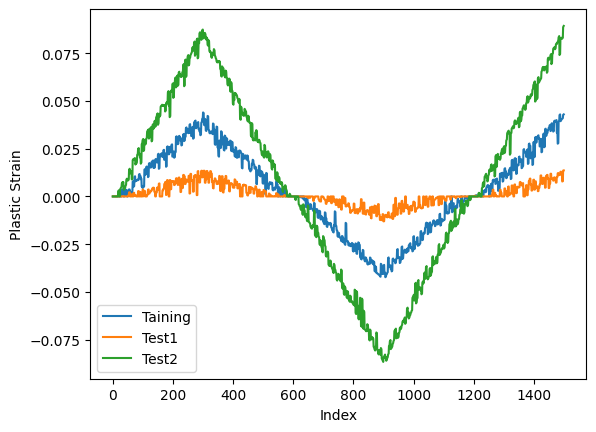

In [22]:

# Example usage
training = generate_dataset(lb=0.0001,ub=0.0002)
save_dataset_to_csv(training)
test1 = generate_dataset(lb=0,ub=0.0001)
test2 = generate_dataset(lb=0.0002,ub=0.0004)

# Plot the plastic strain
columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
df = pd.DataFrame(training, columns=columns)
df1 = pd.DataFrame(test1, columns=columns)
df2 = pd.DataFrame(test2, columns=columns)
df['plastic_strain'].plot()
df1['plastic_strain'].plot()
df2['plastic_strain'].plot()
plt.legend(["Taining", "Test1",'Test2']);
# Add axis labels
plt.xlabel("Index")  # Label for x-axis
plt.ylabel("Plastic Strain")  # Label for y-axis

plt.show()



In [4]:
# Separate features and target
X = training[:, :-1]  # Features (material constants, trial_phi)
y = training[:, -1]   # Targets (|delta_ep|)

# Normalize the dataset
X_normalized, scaler_X = normalize_dataset(X)
y_normalized, scaler_y = normalize_dataset(y.reshape(-1, 1))


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(X_normalized, y_normalized)

# Build the neural network model
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=20,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
history = model.fit(
    X_train, 
    y_train, 
    epochs=1000,              # Set a large number of epochs
    batch_size=1000, 
    validation_split=0.2, 
    callbacks=[early_stopping]  # Include the early stopping callback
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")



Epoch 1/1000


/home/uashfaq/anaconda3/envs/elasticity/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 2.0718 - mae: 1.4138 - val_loss: 2.0440 - val_mae: 1.4050
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.0414 - mae: 1.4030 - val_loss: 2.0139 - val_mae: 1.3943
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.0113 - mae: 1.3923 - val_loss: 1.9841 - val_mae: 1.3835
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.9815 - mae: 1.3815 - val_loss: 1.9546 - val_mae: 1.3728
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.9519 - mae: 1.3708 - val_loss: 1.9254 - val_mae: 1.3622
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.9227 - mae: 1.3601 - val_loss: 1.8964 - val_mae: 1.3515
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.8937 - mae: 1.3494 - val_loss: 1.8678 - val_mae: 1.3409
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8650 - mae: 1.3388 - val_loss: 1.8394 - val_mae: 1.3303
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8366 - mae: 1.3

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


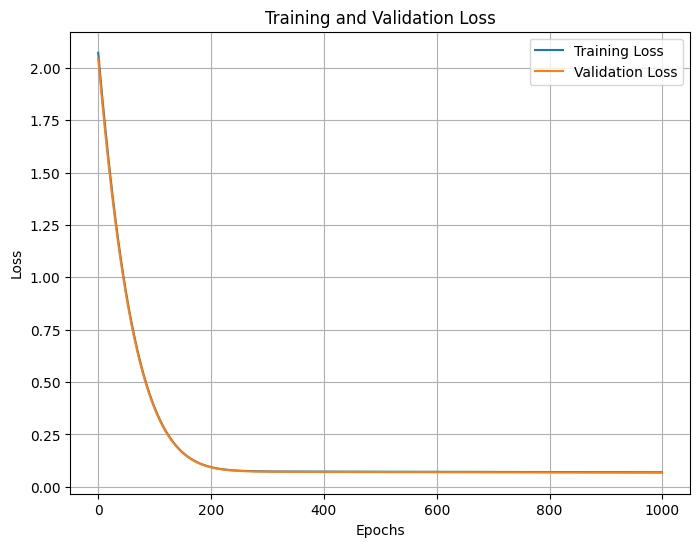

Plot saved as loss_curve


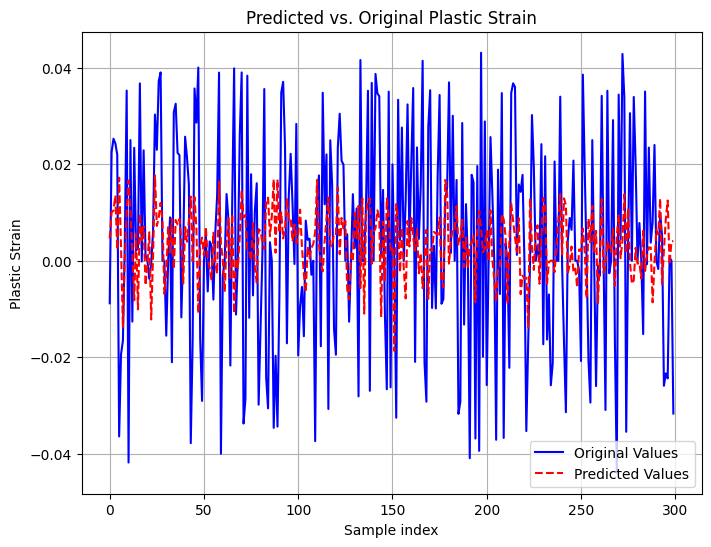

Plot saved as predicted_vs_actual


In [5]:
# Make predictions
y_pred = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denormalized = scaler_y.inverse_transform(y_pred)
y_test_denormalized = scaler_y.inverse_transform(y_test)

# Plot training and validation lossback_stress
plot_loss(history)

# Plot predicted vs original values
plot_predicted_vs_actual(y_test_denormalized, y_pred_denormalized)

In [6]:
X_test1 = test1[:, :-1]  # Features (material constants, trial_phi)
y_test1 = test1[:, -1]   # Targets (|delta_ep|)

In [7]:
# Normalize the dataset
X_test1_normalized, scaler_X = normalize_dataset(X_test1)
y_test1_normalized, scaler_y = normalize_dataset(y_test1.reshape(-1, 1))

In [6]:
# Make predictions
y_test1_pred = model.predict(X_test1_normalized)

# Denormalize predictions and actual values
y_test1_pred_denormalized = scaler_y.inverse_transform(y_test1_pred)
y_test1_denormalized = scaler_y.inverse_transform(y_test1_normalized)


# Plot predicted vs original values
plot_predicted_vs_actual(y_test1_denormalized, y_test1_pred_denormalized)

NameError: name 'model' is not defined

In [24]:
X_test2 = test2[:, :-1]  # Features (material constants, trial_phi)
y_test2 = test2[:, -1]   # Targets (|delta_ep|)

In [25]:
# Normalize the dataset
X_test2_normalized, scaler_X = normalize_dataset(X_test2)
y_test2_normalized, scaler_y = normalize_dataset(y_test2.reshape(-1, 1))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


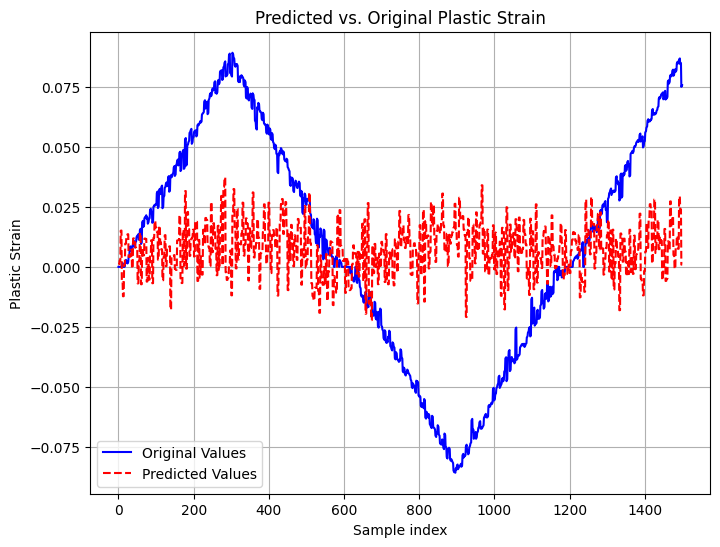

Plot saved as predicted_vs_actual


In [26]:
# Make predictions
y_test2_pred = model.predict(X_test2_normalized)

# Denormalize predictions and actual values
y_test2_pred_denormalized = scaler_y.inverse_transform(y_test2_pred)
y_test2_denormalized = scaler_y.inverse_transform(y_test2_normalized)


# Plot predicted vs original values
plot_predicted_vs_actual(y_test2_denormalized, y_test2_pred_denormalized)